Mounted at /content/drive
Extracted /content/drive/My Drive/real.zip to /content/videos
Extracted /content/drive/My Drive/fake.zip to /content/videos
Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 29s 29s/step - accuracy: 0.0000e+00 - loss: 0.7740 - val_accuracy: 0.0000e+00 - val_loss: 0.8246 - learning_rate: 1.0000e-04
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 1.0000 - loss: 0.6457 - val_accuracy: 0.0000e+00 - val_loss: 1.0084 - learning_rate: 1.0000e-04
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.3539 - val_accuracy: 0.0000e+00 - val_loss: 1.2271 - learning_rate: 1.0000e-04
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.4089 - val_accuracy: 0.0000e+00 - val_loss: 1.4805 - learning_rate: 1.0000e-04
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 1.0000 - loss: 0.2866 - val_accuracy: 0.0000e+00 - val_loss: 1.5352 - learning_rate: 2.0000e-05
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 1.0000 - l

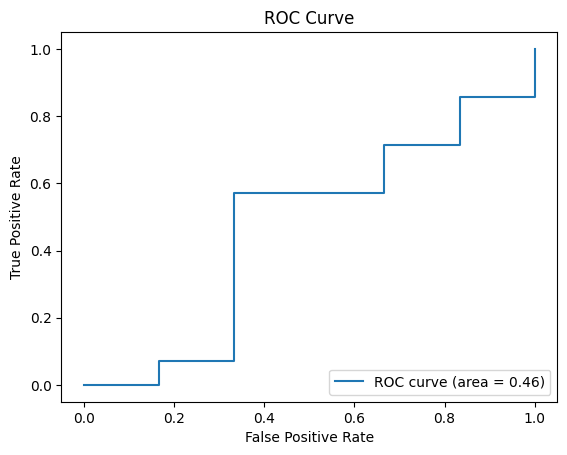

In [ ]:
import os
import numpy as np
import cv2
import zipfile
from google.colab import drive
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Flatten, Input, TimeDistributed, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Mount Google Drive to access files
drive.mount('/content/drive')

# Define paths
real_zip_path = '/content/drive/My Drive/real.zip'
fake_zip_path = '/content/drive/My Drive/fake.zip'
extracted_dir = '/content/videos'

# Unzip files
def unzip_file(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted {zip_path} to {extract_to}")

# Create directory if it does not exist
os.makedirs(extracted_dir, exist_ok=True)

# Extract both ZIP files
unzip_file(real_zip_path, extracted_dir)
unzip_file(fake_zip_path, extracted_dir)

# Function to load frames from video using OpenCV
def load_frames_from_video(video_path, img_size=(64, 64), max_frames=30):
    frames = []
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video file: {video_path}")
        return np.array([])  # Return empty array if video cannot be opened
    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret or frame_count >= max_frames:  # Limit to max_frames
            break
        if frame is not None:
            frame = cv2.resize(frame, img_size)
            frames.append(frame)
            frame_count += 1
    cap.release()
    if frame_count == 0:
        print(f"No frames extracted from video file: {video_path}")
    return np.array(frames)

# Load frames from real and fake videos (ensure consistent number of frames for both)
real_frames = load_frames_from_video('/content/videos/bmgmlkikqi.mp4', max_frames=30)
fake_frames = load_frames_from_video('/content/videos/uxvuxoabmi.mp4', max_frames=30)

# Ensure proper input shape for TimeDistributed: (num_samples, timesteps, height, width, channels)
def preprocess_frames(frames, max_frames=30, img_size=(64, 64)):
    num_frames = frames.shape[0]
    # If the number of frames is less than the max_frames, pad with zeros
    if num_frames < max_frames:
        padding = np.zeros((max_frames - num_frames, img_size[0], img_size[1], 3))
        frames = np.concatenate((frames, padding), axis=0)
    return frames / 255.0  # Normalize to [0,1]

# Preprocess real and fake frames
real_frames = preprocess_frames(real_frames)
fake_frames = preprocess_frames(fake_frames)

# Ensure both have a consistent shape for concatenation
# Add the batch dimension for both real and fake frames (for a single video, batch size = 1)
real_frames = np.expand_dims(real_frames, axis=0)  # Shape: (1, timesteps, height, width, channels)
fake_frames = np.expand_dims(fake_frames, axis=0)  # Shape: (1, timesteps, height, width, channels)

# Concatenate the frames along the batch axis
X = np.concatenate([real_frames, fake_frames], axis=0)  # Shape: (2, timesteps, height, width, channels)
y = np.array([1, 0])  # Labels: 1 for real, 0 for fake

# Define input shape for the model
timesteps = X.shape[1]
height = X.shape[2]
width = X.shape[3]
channels = X.shape[4]
input_shape = (timesteps, height, width, channels)

# Create the CNN-LSTM model with Conv2D in TimeDistributed and Bidirectional LSTM
def create_cnn_lstm_model(input_shape):
    inputs = Input(shape=input_shape)

    # CNN applied to each frame
    x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(inputs)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)

    x = TimeDistributed(Flatten())(x)
    x = TimeDistributed(Dense(256, activation='relu'))(x)
    x = TimeDistributed(Dropout(0.5))(x)

    # Bidirectional LSTM for temporal sequence processing
    x = Bidirectional(LSTM(512, return_sequences=True, dropout=0.5))(x)
    x = Bidirectional(LSTM(256, dropout=0.5))(x)

    # Output layer
    outputs = Dense(1, activation='sigmoid')(x)

    # Model compilation
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Build the model
model = create_cnn_lstm_model(input_shape)

# Split the data for training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
checkpoint = ModelCheckpoint('/content/best_model.keras', save_best_only=True)

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=2,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Load the best model for evaluation
model.load_weights('/content/best_model.keras')

# Dummy test data generation
def create_dummy_data(num_samples, timesteps, height, width, channels):
    return np.random.random((num_samples, timesteps, height, width, channels)), np.random.randint(0, 2, num_samples)

X_test, y_test = create_dummy_data(20, timesteps, height, width, channels)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# ROC Curve
y_pred = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
